In [54]:
import numpy as np
import holoviews as hv
from holoviews import opts
hv.extension('matplotlib', logo=False)
from matplotlib import pyplot as plt
import kwant
# import tinyarray as tiny
import sys #one day I will move everything into different py files to make the code a bit cleaner
sys.path.append('Jupyter')
from functions import pauli

## 2 June
- Edited skyrmion so that it fits in a square Kwant system and attached leads

In [55]:
sigma = np.moveaxis(np.array([pauli.s0sx,pauli.s0sy, pauli.s0sz]),0,2)

def magn_texture(position, radius=10, azi_winding=1, radi_winding=1):
    x,y = position
    theta = np.arctan2(x,y)
    q = azi_winding
    p = radi_winding
    R = radius
    r = np.sqrt(x**2 + y**2)
    if r < (radius):
        B = np.array([np.sin(np.pi*p*((r)/R))*np.cos(q*theta), np.sin(np.pi*p*((r)/R))*np.sin(q*theta), np.cos(np.pi*p*((r)/R))])
    else:
        B = np.array([0,0,0])
    return B


def scattering_onsite(site, J, radius, azi_winding, radi_winding):
    B = magn_texture(site.pos, radius=radius, azi_winding=azi_winding, radi_winding=radi_winding)
    return J * np.dot(sigma, B)

def hopping(position1, position2, t): #define the hopping terms in your system
    return -t*pauli.szs0

def lead_onsite(site, J):
    return pauli.s0s0

lat = kwant.lattice.square(norbs=1)

def make_system(L=80):

    syst = kwant.Builder()

    def square(pos): #only gives squares for uneven lengths
        return all(-L/2 < p < L/2 for p in pos)

    syst[lat.shape(square, (0, 0))] = scattering_onsite
    syst[lat.neighbors()] = hopping

    lead = kwant.Builder(kwant.TranslationalSymmetry((-1, 0))) #, conservation_law=-sigma_z

    lead[lat.shape(square, (0, 0))] = lead_onsite
    lead[lat.neighbors()] = hopping

    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())

    return syst

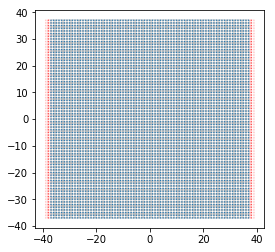

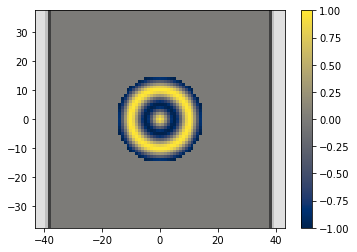

In [69]:
L=75
sys = make_system(L=L).finalized()
params = dict(J=1, t=1, radius=15, azi_winding=1, radi_winding=3)
ham = sys.hamiltonian_submatrix(params=params, sparse=True)

b_z = np.real(ham.diagonal()[::4]) #Since our function now only contains the magnetic term, we take out one of the z_components to check

sys_plot = kwant.plot(sys)
kwant.plotter.map(sys, b_z, cmap='cividis', oversampling=1, num_lead_cells=2, vmin=-1, vmax=1);